In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

name_subj = "S7"
epoch_size = [-.1, 1]#epoch size, in seconds
baseline = int(epoch_size[0]*1000)

%matplotlib notebook

# Loading pre-processed data

In [2]:
raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj,preload=True) 

Opening raw data file ../preprocessed_data/preprocessed_S7.fif...


<ipython-input-2-8573f607c2db>:1: RuntimeWarning: This filename (../preprocessed_data/preprocessed_S7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj,preload=True)


    Range : 0 ... 4881407 =      0.000 ...  4766.999 secs
Ready.
Reading 0 ... 4881407  =      0.000 ...  4766.999 secs...


### Filtering 

In [3]:
raw.filter(l_freq=None, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 sec)



<Raw | preprocessed_S7.fif, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

### Creating epochs

In [4]:
#Trigger = force (low/high); SAT (speed,accuracy), expdResp (left,right), contrast (1,2,3)
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/accuracy/right/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/accuracy/right/3':2223,} # used for segmentation

#Triggers had to be merged as I had to send the force on a different timing due to bit size constraints
original_evts = pd.read_csv('../preprocessing/%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.iloc[np.where(np.isin(original_evts.code,list(trig_id.values())))]#Removing all triggers not in the dict
evts = evts.values#from pandas to numpy
evts[:,2] = evts[:,1]#Adapting to MNE format

epochs = mne.Epochs(raw, evts, event_id=trig_id, tmin=epoch_size[0], tmax=epoch_size[1],preload=True, picks='eeg')
epochs = epochs.resample(1000)#Downsample from 1024 to 1000Hz in order to have a 1-to1 correspondance between time and sample

Not setting metadata
Not setting metadata
2448 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2448 events and 1127 original time points ...
117 bad epochs dropped


<IPython.core.display.Javascript object>


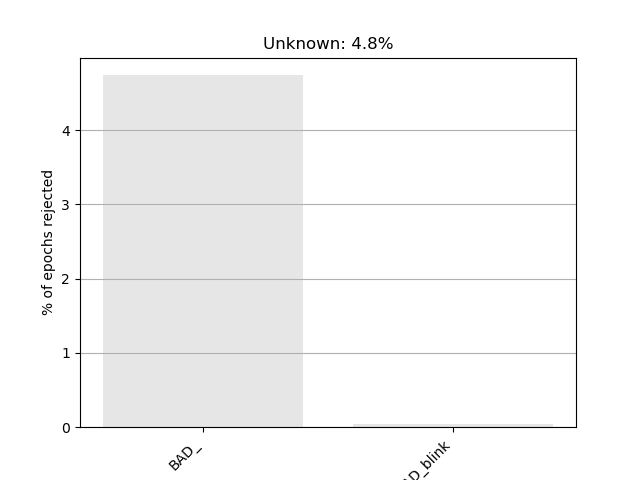

In [5]:
epochs.plot_drop_log();#Checking the amount of dropped trials

# Computing ERP

In [6]:
#Could be used to equalize number of trials, not used for now
#epochs.equalize_event_counts(list([x for x in trig_id.keys()])) 
#epochs

### ERP function of contrast

<IPython.core.display.Javascript object>


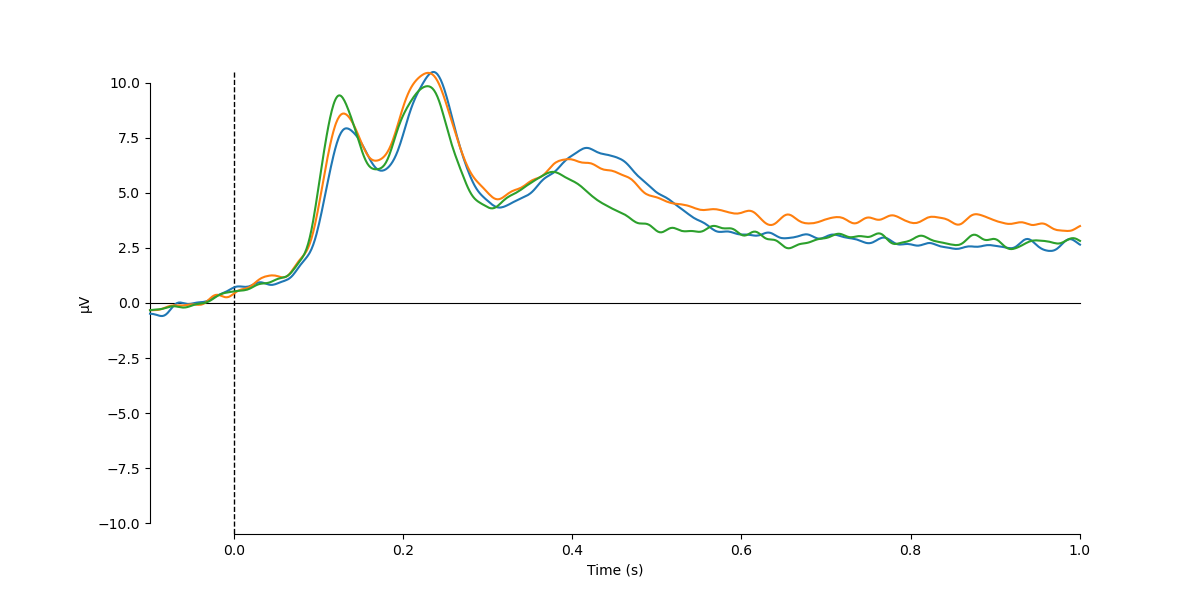

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
Time at min amplitude : 0.174391
Time at min amplitude : 0.167391
Time at min amplitude : 0.167391


In [7]:
low_contrast_evoked = epochs['1'].average( picks=['PO7','PO8','P7','P8'])
mid_contrast_evoked = epochs['2'].average( picks=['PO7','PO8','P7','P8'])
high_contrast_evoked = epochs['3'].average( picks=['PO7','PO8','P7','P8'])

fig, ax = plt.subplots(1,1, figsize=(12,6))
mne.viz.plot_compare_evokeds(dict(low=low_contrast_evoked, mid=mid_contrast_evoked, high=high_contrast_evoked),
                             axes=ax,legend='upper left', show_sensors='upper right', combine='mean');

i=0
for evoked in [low_contrast_evoked,mid_contrast_evoked,high_contrast_evoked]:
    min_amp = evoked.times[np.where(evoked.data.mean(axis=0) == evoked.data.mean(axis=0)[250:350].min())]
    ax.vlines(min_amp, -40,40,lw=1,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    print('Time at min amplitude : %f'%(min_amp))
    i+=1


### ERP function of SAT

<IPython.core.display.Javascript object>


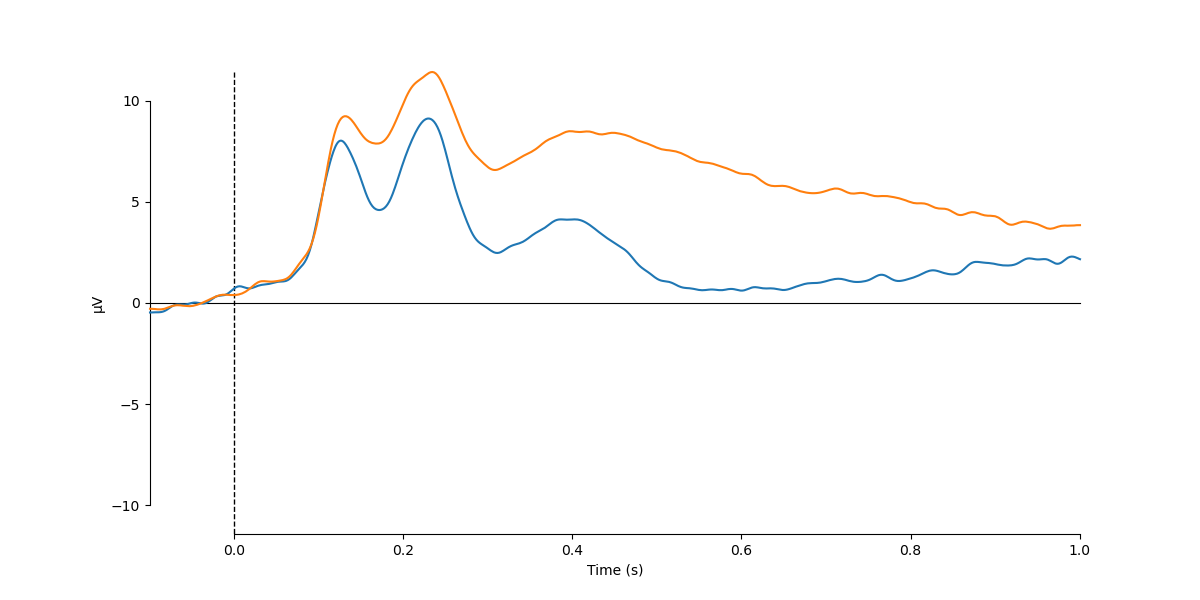

combining channels using "mean"
combining channels using "mean"
Time at min amplitude : 0.171391
Time at min amplitude : 0.169391


In [8]:
speed_evoked = epochs['speed'].average(picks=['PO7','PO8','P7','P8'])
accuracy_evoked = epochs['accuracy'].average(picks=['PO7','PO8','P7','P8'])

fig, ax = plt.subplots(1,1, figsize=(12,6))
mne.viz.plot_compare_evokeds(dict(speed=speed_evoked, accuracy=accuracy_evoked), axes=ax,
                             legend='upper left', show_sensors='upper right', combine='mean');

i=0
for evoked in [speed_evoked,accuracy_evoked]:
    min_amp = evoked.times[np.where(evoked.data.mean(axis=0) == evoked.data.mean(axis=0)[250:350].min())]
    ax.vlines(min_amp, -40,40,lw=1,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    print('Time at min amplitude : %f'%(min_amp))
    i+=1

### ERP function of Force Condition

<IPython.core.display.Javascript object>


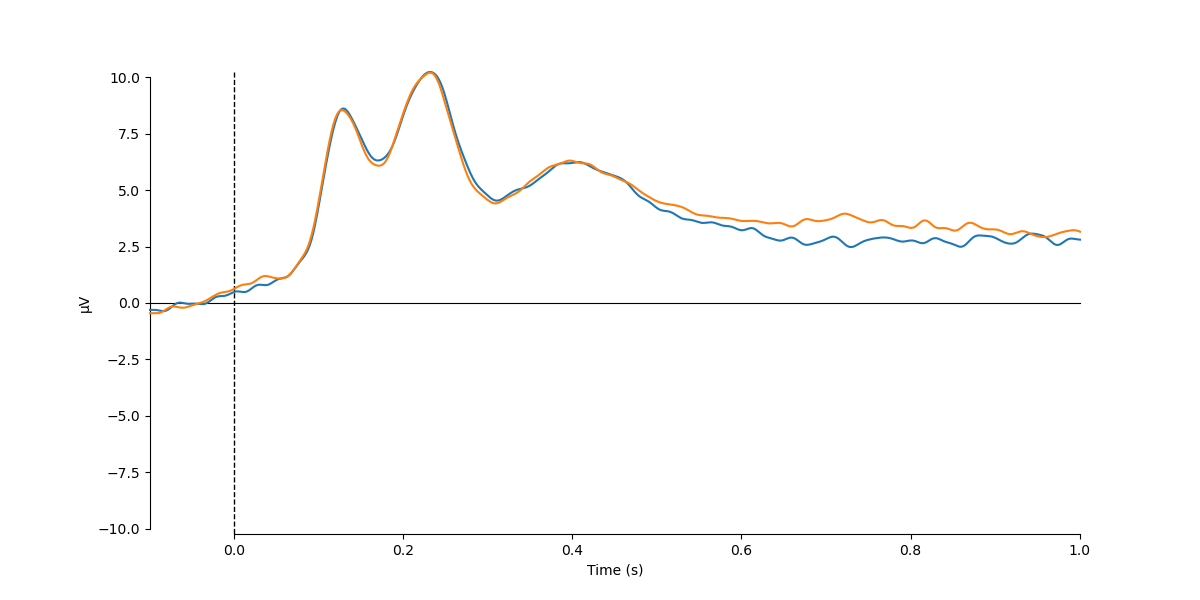

combining channels using "mean"
combining channels using "mean"
Time at min amplitude : 0.169391
Time at min amplitude : 0.171391


In [9]:
low_force_evoked = epochs['low'].average(picks=['PO7','PO8','P7','P8'])
high_force_evoked = epochs['high'].average(picks=['PO7','PO8','P7','P8'])

fig, ax = plt.subplots(1,1, figsize=(12,6))

mne.viz.plot_compare_evokeds(dict(low=low_force_evoked, high=high_force_evoked),axes=ax,
                             legend='upper left', show_sensors='upper right', combine='mean');

i=0
for evoked in [low_force_evoked,high_force_evoked]:
    min_amp = evoked.times[np.where(evoked.data.mean(axis=0) == evoked.data.mean(axis=0)[250:350].min())]
    ax.vlines(min_amp, -40,40,lw=1,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    print('Time at min amplitude : %f'%(min_amp))
    i+=1

### ERP function of SAT $\times$ contrast

In [10]:
low_contrast_speed_evoked = epochs['speed/1'].average(picks=['PO7','PO8','P7','P8'])
mid_contrast_speed_evoked = epochs['speed/2'].average(picks=['PO7','PO8','P7','P8'])
high_contrast_speed_evoked = epochs['speed/3'].average(picks=['PO7','PO8','P7','P8'])
low_contrast_accuracy_evoked = epochs['accuracy/1'].average(picks=['PO7','PO8','P7','P8'])
mid_contrast_accuracy_evoked = epochs['accuracy/2'].average(picks=['PO7','PO8','P7','P8'])
high_contrast_accuracy_evoked = epochs['accuracy/3'].average(picks=['PO7','PO8','P7','P8'])

<IPython.core.display.Javascript object>


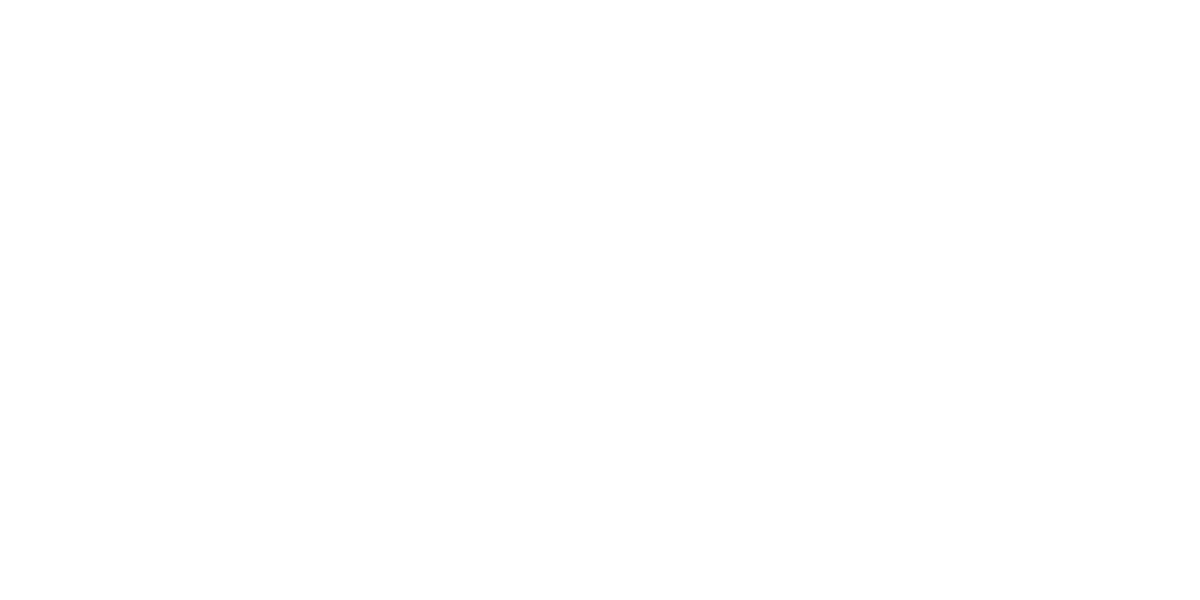

In [11]:
ls_dict = {'accuracy':'-', 'speed':'--'}
colors_dict = {'1':'red', '2':'orange','3':'green'}
fig, ax = plt.subplots(1,1, figsize=(12,6))

for cond in [low_contrast_speed_evoked, mid_contrast_speed_evoked,high_contrast_speed_evoked,low_contrast_accuracy_evoked,mid_contrast_accuracy_evoked,high_contrast_accuracy_evoked]:
    cont_cond = cond.comment.split('+')[0][-2]
    spd_cond = cond.comment.split('/')[1]
    ax.plot(cond.times,cond.data.mean(axis=0), c= colors_dict[cont_cond], ls=ls_dict[spd_cond], label = "%s : %s" %(spd_cond, cont_cond))
    
ax.vlines(0,-4e-6,6e-6,ls='--')
plt.xlim(-0.1,1)
plt.legend();

## Topomap for grand average

<IPython.core.display.Javascript object>


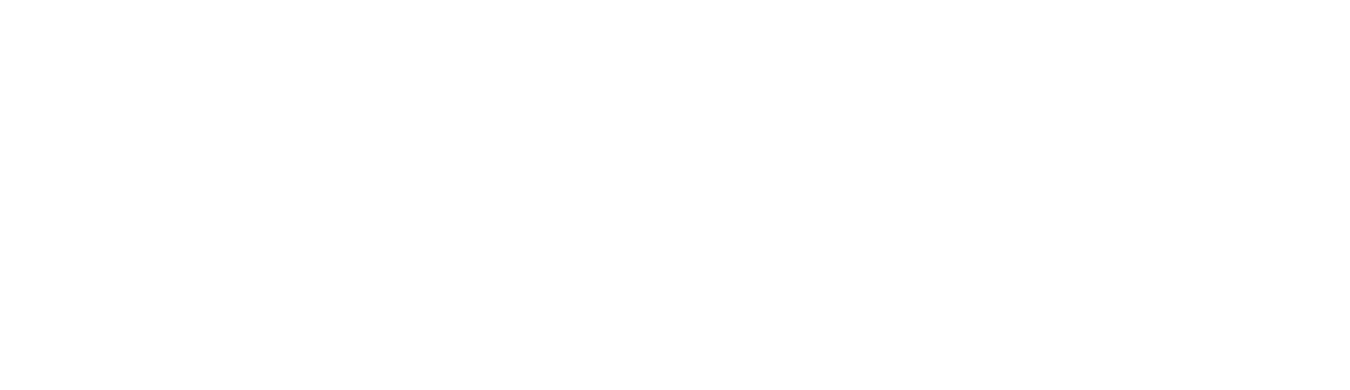

In [12]:
epochs.average().plot_topomap(times=np.arange(0, 0.8, 0.05), ch_type='eeg', ncols=8, nrows='auto');

Comparing ERP elicted by contrast for each electrode 

<IPython.core.display.Javascript object>


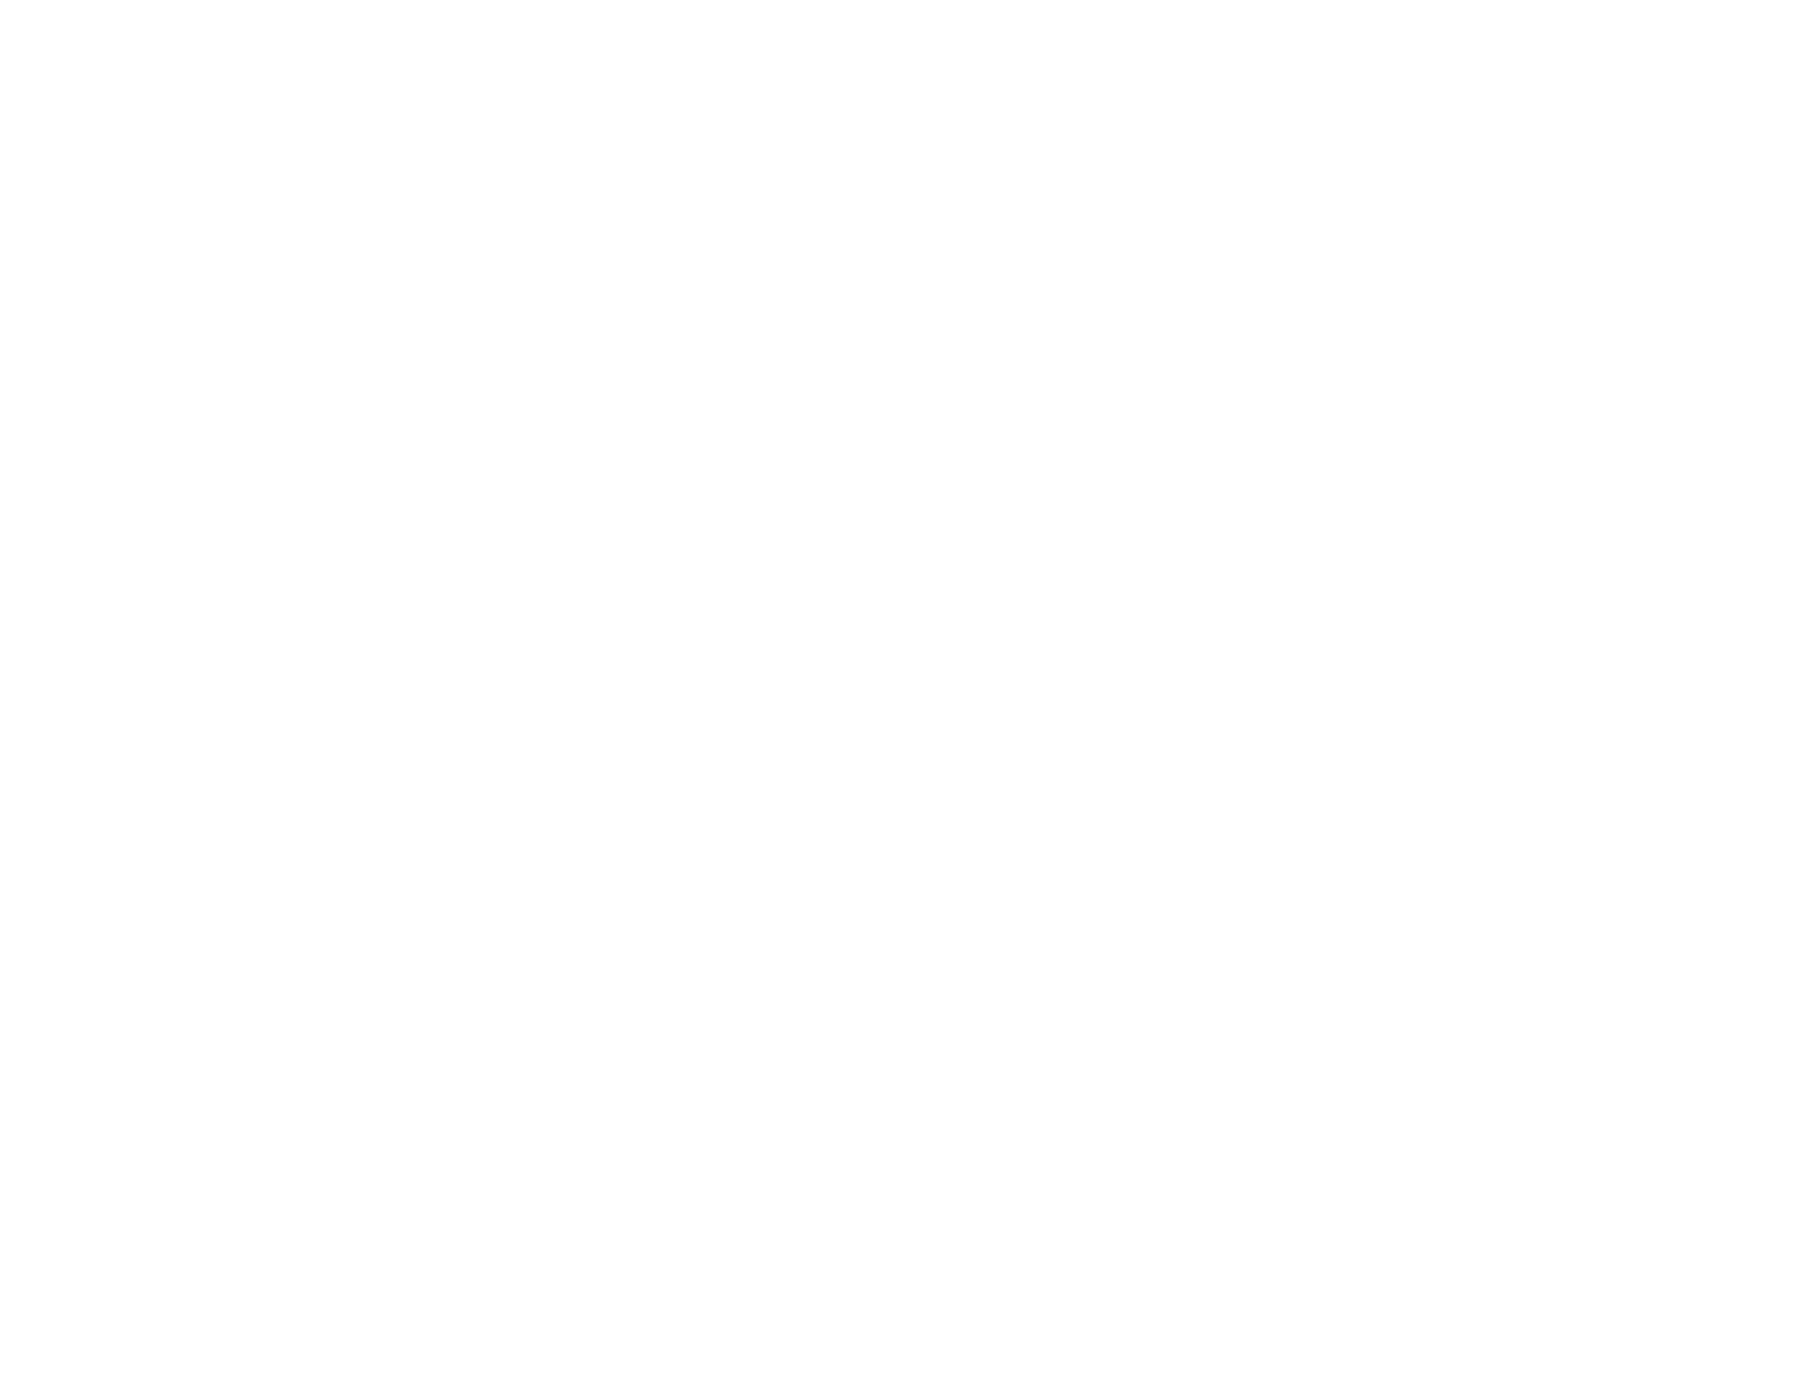

[<Figure size 1800x1400 with 65 Axes>]

In [13]:
low_contrast_evoked = epochs['1'].average()
mid_contrast_evoked = epochs['2'].average()
high_contrast_evoked = epochs['3'].average()

mne.viz.plot_compare_evokeds([low_contrast_evoked,mid_contrast_evoked,high_contrast_evoked], picks='eeg',
                             axes='topo')

## Link between RT and N200

Recovering RTs

In [14]:
data_EMG = pd.read_csv('../../processing_EMG/extracted_df.csv', sep=',')
data_EMG = data_EMG[data_EMG.participant == name_subj]
data_EMG['epoch'] = np.arange(len(data_EMG))
data_EMG['rt'] = data_EMG['resp_time'] - data_EMG['stim_time']
data_EMG['SAT_contrast'] = [int(str(x)[0] + str(x)[2]) for x in data_EMG.stim_code]#removing trigger from the middle as it contains expdResp

In [15]:
epoch_retained = epochs.to_data_frame(picks=['Fp1'])['epoch'].unique()#Store epochs that werent dropped during creation of the epochs
len(epoch_retained)
#del epochdf

2331

In [16]:
for condition, cond_dat in data_EMG.groupby('SAT_contrast'):
    trials = data_EMG[data_EMG.SAT_contrast == condition]#Binning within SAT and contrast experimental cells
    trials = trials[np.isin(trials.epoch, epoch_retained)]#Only compute RT bins on trials not excluded by preprocessing
    if len(trials[np.isnan(trials.rt)]) > 0 :
        print('Mean RT imputed on %i trial(s) in %i' %(len(trials[np.isnan(trials.rt)]), condition))
        data_EMG.loc[trials[np.isnan(trials.rt)].index, 'rt'] = np.mean(trials.rt)
        trials = data_EMG[data_EMG.SAT_contrast == condition]#Binning within SAT and contrast experimental cells
    data_EMG.loc[trials.index, 'rt_bins'] = np.digitize(trials.rt, np.quantile(trials.rt, [.25,.5,.75]))


Mean RT imputed on 5 trial(s) in 11
Mean RT imputed on 7 trial(s) in 12
Mean RT imputed on 6 trial(s) in 13


In [17]:
new_triggers = data_EMG.apply(lambda row : int(str(row['SAT_contrast']) + str(int(row['rt_bins']))) if np.isfinite(row['rt_bins']) else 0, axis=1)
#New triggers = SAT (0 or 1); contrast  (1,2,3); RTbin (0,1,2,3)

In [18]:
data_EMG.groupby(['SAT_contrast','rt_bins']).count().epoch

SAT_contrast  rt_bins
11            0.0        102
              1.0        100
              2.0        104
              3.0        102
12            0.0        102
              1.0        101
              2.0        102
              3.0        103
13            0.0        102
              1.0        102
              2.0        102
              3.0        102
21            0.0         96
              1.0         92
              2.0         99
              3.0         96
22            0.0         95
              1.0         94
              2.0         95
              3.0         95
23            0.0         94
              1.0         93
              2.0         94
              3.0         94
Name: epoch, dtype: int64

In [19]:
trig_id_binned = {'speed/1/rt_0':110,'speed/1/rt_1':111,'speed/1/rt_2':112,'speed/1/rt_3':113,
          'speed/2/rt_0':120,'speed/2/rt_1':121,'speed/2/rt_2':122,'speed/2/rt_3':123,
          'speed/3/rt_0':130,'speed/3/rt_1':131,'speed/3/rt_2':132,'speed/3/rt_3':133,
          'accuracy/1/rt_0':210,'accuracy/1/rt_1':211,'accuracy/1/rt_2':212,'accuracy/1/rt_3':213,
          'accuracy/2/rt_0':220,'accuracy/2/rt_1':221,'accuracy/2/rt_2':222,'accuracy/2/rt_3':223,
          'accuracy/3/rt_0':230,'accuracy/3/rt_1':231,'accuracy/3/rt_2':232,'accuracy/3/rt_3':233,} # used for segmentation

original_evts = pd.read_csv('../preprocessing/%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.iloc[np.where(np.isin(original_evts.code,list(trig_id.values())))]
evts = evts.values
evts[:,2] = new_triggers #replacing with new triggers

epochs_rt = mne.Epochs(raw, evts, event_id=trig_id_binned, tmin=epoch_size[0], tmax=epoch_size[1],preload=True, picks='eeg')
epochs_rt = epochs_rt.resample(1000)#Downsample from 1024 to 1000Hz in order to have a 1-to1 correspondance between time and sample

Not setting metadata
Not setting metadata
2361 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2361 events and 1127 original time points ...
30 bad epochs dropped


### ERP by RT in speed

<IPython.core.display.Javascript object>


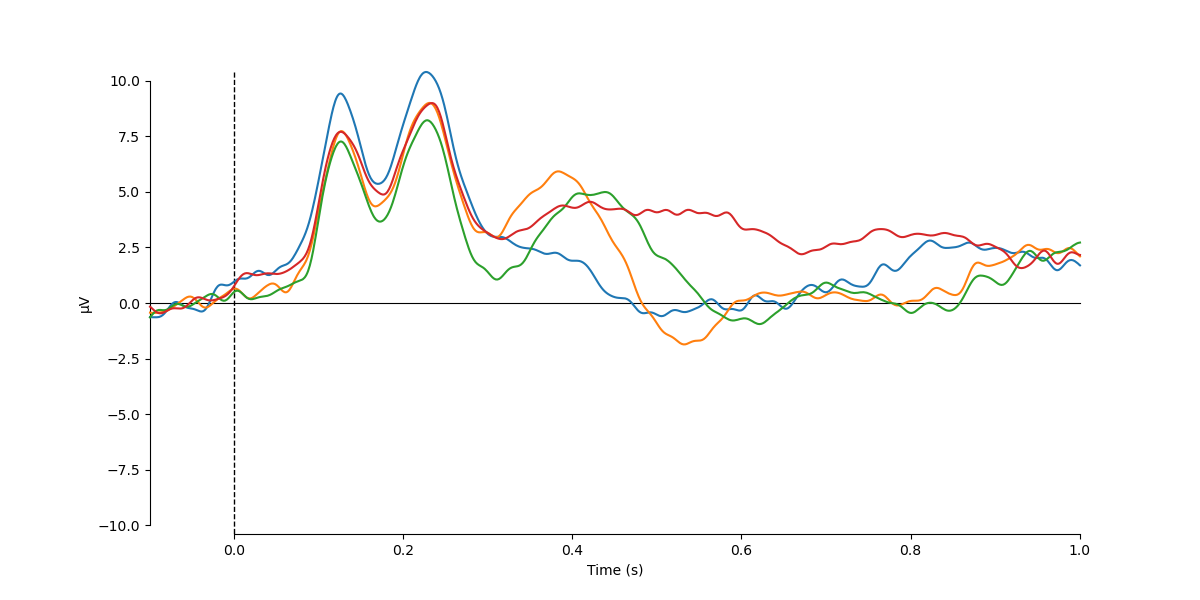

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
Time at min amplitude : 0.299391
Time at min amplitude : 0.299391
Time at min amplitude : 0.299391
Time at min amplitude : 0.299391


In [20]:
Q1_rt_evoked = epochs_rt['speed/rt_0'].average(picks=['PO7','PO8','P7','P8'])
Q2_rt_evoked = epochs_rt['speed/rt_1'].average(picks=['PO7','PO8','P7','P8'])
Q3_rt_evoked = epochs_rt['speed/rt_2'].average(picks=['PO7','PO8','P7','P8'])
Q4_rt_evoked = epochs_rt['speed/rt_3'].average(picks=['PO7','PO8','P7','P8'])

fig, ax = plt.subplots(1,1, figsize=(12,6))

mne.viz.plot_compare_evokeds(dict(Q1=Q1_rt_evoked, Q2=Q2_rt_evoked, Q3=Q3_rt_evoked, Q4=Q4_rt_evoked), axes=ax,
                             legend='upper left', show_sensors='upper right', combine='mean');

i=0
for evoked in [Q1_rt_evoked,Q2_rt_evoked,Q3_rt_evoked,Q4_rt_evoked]:
    min_amp = evoked.times[np.where(evoked.data.mean(axis=0) == evoked.data.mean(axis=0)[200:400].min())]
    ax.vlines(min_amp, -40,40,lw=1,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    print('Time at min amplitude : %f'%(min_amp))
    i+=1

### ERP by RT in accuracy

<IPython.core.display.Javascript object>


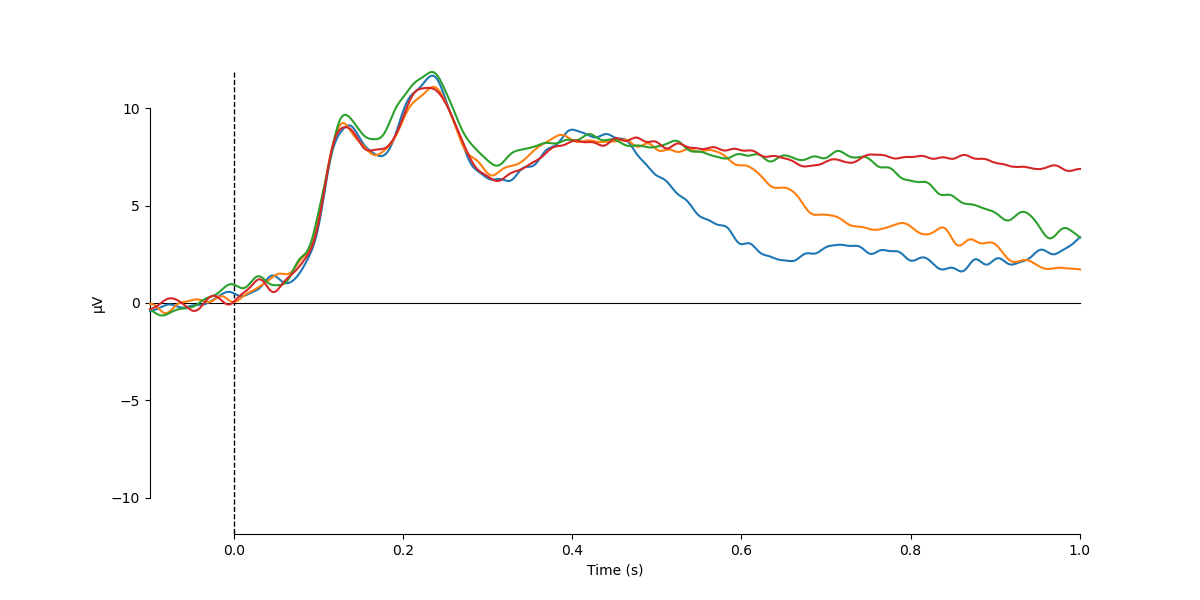

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
Time at min amplitude : 0.100391
Time at min amplitude : 0.100391
Time at min amplitude : 0.100391
Time at min amplitude : 0.100391


In [21]:
Q1_rt_evoked = epochs_rt['accuracy/rt_0'].average(picks=['PO7','PO8','P7','P8'])
Q2_rt_evoked = epochs_rt['accuracy/rt_1'].average(picks=['PO7','PO8','P7','P8'])
Q3_rt_evoked = epochs_rt['accuracy/rt_2'].average(picks=['PO7','PO8','P7','P8'])
Q4_rt_evoked = epochs_rt['accuracy/rt_3'].average(picks=['PO7','PO8','P7','P8'])

fig, ax = plt.subplots(1,1, figsize=(12,6))

mne.viz.plot_compare_evokeds(dict(Q1=Q1_rt_evoked, Q2=Q2_rt_evoked, Q3=Q3_rt_evoked, Q4=Q4_rt_evoked), axes=ax,
                             legend='upper left', show_sensors='upper right', combine='mean');

i=0
for evoked in [Q1_rt_evoked,Q2_rt_evoked,Q3_rt_evoked,Q4_rt_evoked]:
    min_amp = evoked.times[np.where(evoked.data.mean(axis=0) == evoked.data.mean(axis=0)[200:400].min())]
    ax.vlines(min_amp, -40,40,lw=1,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    print('Time at min amplitude : %f'%(min_amp))
    i+=1

In [22]:
del epochs_rt

## Exporting epochs for later group analysis

In [23]:
low_FC_low_contrast_speed_evoked = epochs['low/speed/1'].average()
low_FC_mid_contrast_speed_evoked = epochs['low/speed/2'].average()
low_FC_high_contrast_speed_evoked = epochs['low/speed/3'].average()
low_FC_low_contrast_accuracy_evoked = epochs['low/accuracy/1'].average()
low_FC_mid_contrast_accuracy_evoked = epochs['low/accuracy/2'].average()
low_FC_high_contrast_accuracy_evoked = epochs['low/accuracy/3'].average()
high_FC_low_contrast_speed_evoked = epochs['high/speed/1'].average()
high_FC_mid_contrast_speed_evoked = epochs['high/speed/2'].average()
high_FC_high_contrast_speed_evoked = epochs['high/speed/3'].average()
high_FC_low_contrast_accuracy_evoked = epochs['high/accuracy/1'].average()
high_FC_mid_contrast_accuracy_evoked = epochs['high/accuracy/2'].average()
high_FC_high_contrast_accuracy_evoked = epochs['high/accuracy/3'].average()

mne.write_evokeds('N200_epochs/%s-ave.fif'%name_subj, [low_FC_low_contrast_speed_evoked, 
                             low_FC_mid_contrast_speed_evoked,
                             low_FC_high_contrast_speed_evoked,
                             low_FC_low_contrast_accuracy_evoked,
                             low_FC_mid_contrast_accuracy_evoked,
                             low_FC_high_contrast_accuracy_evoked,
                             high_FC_low_contrast_speed_evoked,
                             high_FC_mid_contrast_speed_evoked,
                             high_FC_high_contrast_speed_evoked,
                             high_FC_low_contrast_accuracy_evoked,
                             high_FC_mid_contrast_accuracy_evoked,
                             high_FC_high_contrast_accuracy_evoked])

In [24]:
%matplotlib inline

# Extracting single trial N200

## Applying same filter as Nunez 2019

In [25]:
raw.filter(l_freq=1, h_freq=10)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 3379 samples (3.300 sec)



<Raw | preprocessed_S7.fif, 72 x 4881408 (4767.0 s), ~2.62 GB, data loaded>

### Creating epochs on newly filtered data

In [26]:
#Trigger = force (low/high); SAT (speed,accuracy), expdResp (left,right), contrast (1,2,3)
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/accuracy/right/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/accuracy/right/3':2223,} # used for segmentation

#Triggers had to be merged as I had to send the force on a different timing due to bit size constraints
original_evts = pd.read_csv('../preprocessing/%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.iloc[np.where(np.isin(original_evts.code,list(trig_id.values())))]#Removing all triggers not in the dict
evts = evts.values#from pandas to numpy
evts[:,2] = evts[:,1]#Adapting to MNE format

epochs = mne.Epochs(raw, evts, event_id=trig_id, tmin=epoch_size[0], tmax=epoch_size[1],preload=True, picks='eeg')
epochs = epochs.resample(1000)#Downsample from 1024 to 1000Hz in order to have a 1-to1 correspondance between time and sample

Not setting metadata
Not setting metadata
2448 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2448 events and 1127 original time points ...
117 bad epochs dropped


## First computing traditional ERP without considering conditions

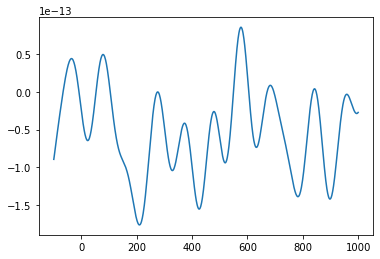

In [27]:
#Matrix electrode X times
electrode_average_data = []
for electrode in epochs.ch_names:
    electrode_average_data.append(np.mean(epochs.get_data(picks=electrode),axis=0)[0]) 
electrode_average_data = np.transpose(electrode_average_data)
electrode_average_data = pd.DataFrame(electrode_average_data)
electrode_average_data.columns = epochs.ch_names
#Simple plot of the raw ERP : mean of all electrodes aligned to stimulus
plt.plot(electrode_average_data.index.values+baseline,np.mean(electrode_average_data,axis=1));

## Applying PCA (SVD)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)#Selecting only the 3 first components

PCs = pca.fit_transform(electrode_average_data)#PCA module centers data, default is SVD

PCs_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2','PC3'])
PCs_df.index = PCs_df.index.values + epochs.tmin*1000 #Aligining index of PCs with times froms epochs

#### Plotting ERP in the PC domain

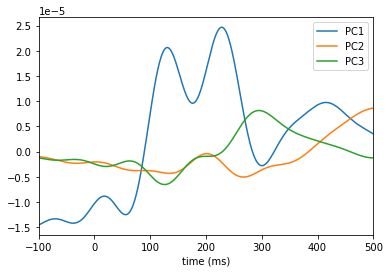

In [29]:
plt.plot(PCs_df.index, PCs_df.PC1, label='PC1');
plt.plot(PCs_df.index, PCs_df.PC2, label='PC2');
plt.plot(PCs_df.index, PCs_df.PC3, label='PC3');

plt.xlabel('time (ms)')
plt.xlim(-100,500)
plt.legend();


#### Explained variance ratio

In [30]:
print(pca.explained_variance_ratio_)

[0.7701858  0.12664942 0.06763071]


#### Scalp map based on the weights

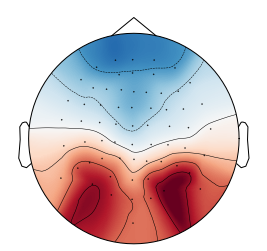

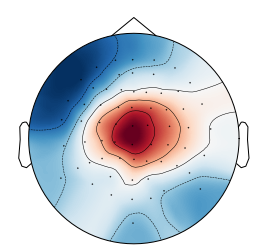

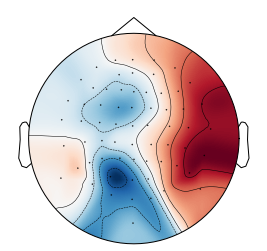

In [31]:
for comp in np.arange(pca.n_components):#Plots in PC order: 1,2,3
    mne.viz.plot_topomap(pca.components_[comp], pos=epochs.info)
    plt.show()


In [32]:
selected_PC = 0
window = np.arange(125,250)

## Projecting to data

In [33]:
pca_epoch_data = np.transpose(epochs.get_data(),(1,0,2))

In [34]:
pca_chan = []
for epoch in range(np.shape(pca_epoch_data)[1]):
    for electrode in range(len(pca_epoch_data[:,epoch,:])):
        pca_epoch_data[electrode,epoch,:] = pca_epoch_data[electrode,epoch,:] * pca.components_[selected_PC][electrode]
    pca_chan.append(np.sum(pca_epoch_data[:,epoch,:], axis=0))#Sum of the weighted electrodes
pca_chan = np.array(pca_chan)

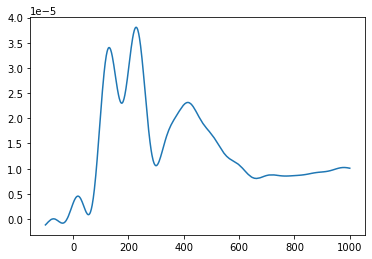

In [35]:
plt.plot(np.arange(np.shape(pca_chan)[1])-100, np.mean(pca_chan, axis=0)); #Plotting the PCA weighted channel

# Viewing single trial

### Example of time course on 6 randomly selected epochs with the window for N200 estimate

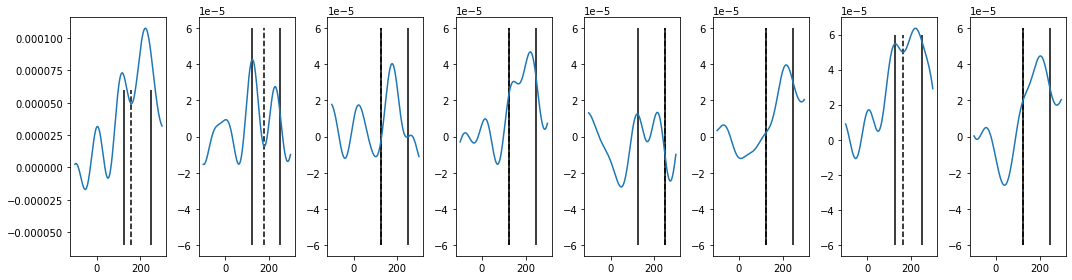

In [36]:
n_epochs = 8
fig, ax = plt.subplots(1,n_epochs, figsize=(15,4))
i = 0
for epoch in np.random.choice(np.arange(len(np.mean(pca_epoch_data, axis=0)[:,0])),size=n_epochs):#randomly selecting epochs
    ax[i].plot(np.arange(400)+baseline, pca_chan[epoch][:400]);
    ax[i].vlines(window[0], -6e-5,6e-5)
    ax[i].vlines(window[-1], -6e-5,6e-5)
    ax[i].vlines(np.where(pca_chan[epoch,window-baseline] == np.min(pca_chan[epoch,window-baseline]))[0]+window[0],-6e-5,6e-5, ls='--')
    i += 1
plt.tight_layout()

In [37]:
N200 = []
for epoch in np.arange(len(pca_chan[:,0])):#Calculating single trial N200
    N200.append(int(np.where(pca_chan[epoch,window-baseline] == np.min(pca_chan[epoch,window-baseline]))[0]+window[0]))

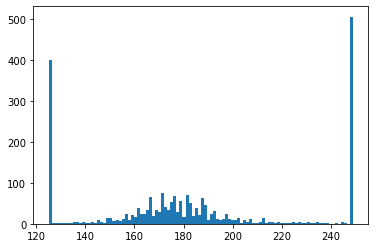

In [38]:
plt.hist(N200,bins=100);#Plotting the distribution of the single trial N200

In [39]:
#Printing the amount of trials == to lowest or highest value in window
(len(np.where(N200 == window[-1])[0]) + len(np.where(N200 == window[0])[0] ))/len(pca_chan[:,0])

0.38824538824538823

In [40]:
#Reconstructing conditions etc., exporting to dataframe
trials = epochs.to_data_frame()[['epoch','condition','time']].groupby(['epoch','condition']).mean().reset_index()
trial_index = trials.epoch
trials = pd.DataFrame(trials.condition.str.split('/').tolist(),
                                 columns = ['FC','SAT','expdResp','contrast'])
trials['N200'] = N200
trials['trial'] = trial_index
trials.N200 = trials.apply(lambda row: np.nan if row['N200'] == window[-1] or row['N200'] == window[0] else row['N200'], axis=1)
trials.to_csv('%s_N200.csv'%name_subj)